PSP VDFs

In [1]:
#Import modules
import glob
import os
import wget
import cdflib
import numpy as np
# import datetime
from datetime import datetime
import os.path
import bisect

from scipy.optimize import curve_fit
from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")
import scipy.optimize as opt
from scipy.signal import savgol_filter
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

import astropy.units as u
import astropy.constants as const
from scipy.stats import moment
from scipy.signal import find_peaks

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import cm
from IPython.display import HTML
import matplotlib as mpl
import pyspedas
from datetime import datetime
from pyspedas import time_string
from pytplot import tplot, store_data, get_data ,tlimit,xlim,ylim,tplot_options,options,split_vec,cdf_to_tplot,divide,tplot_names,get_timespan, tplot_rename, time_datetime


In [2]:
#Download data if not available offline
timeslice= datetime(2022, 2, 25)

year  = timeslice.year
month = timeslice.month
day   = timeslice.day
user_datetime = datetime(year,month,day)

def yyyymmdd(dt) : return f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

#Import from file directory
VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{yyyymmdd(user_datetime)}_v04.cdf'

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(VDfile_filename):
    print(f"File already exists in local directory - [{VDfile_filename}]")
    VDfile = VDfile_filename
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

#open CDF file
dat = cdflib.CDF(VDfile)

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)
epoch           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
data            = cdf_VDfile['DATA']
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))

File already exists in local directory - [psp_swp_spi_sf00_L2_8Dx32Ex8A_20220225_v04.cdf]
([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


In [3]:
#extracting the average data frame value of VDF for each epoch.. It process each VDF, so takes long time
start_time=np.datetime64(datetime(2022,2,25,14, 30, 00))
end_time=np.datetime64(datetime(2022,2,25,16, 30, 00))

t_index_st  = bisect.bisect_right(epoch,start_time)
t_index_et  = bisect.bisect_left(epoch,end_time)

epoch_vdf=epoch[t_index_st:t_index_et]

firstit = True

for t in range(t_index_st,t_index_et):
    
    tSliceIndex = t
    print(epoch[t])
    epochSlice = epoch[tSliceIndex]
    thetaSlice = theta[tSliceIndex, :]
    phiSlice = phi[tSliceIndex, :]
    energySlice = energy[tSliceIndex, :]
    efluxSlice = eflux[tSliceIndex, :]
    dataSlice = data[tSliceIndex, :]

    thetaReshaped = thetaSlice.reshape((8, 32, 8))
    phiReshaped = phiSlice.reshape((8, 32, 8))
    energyReshaped = energySlice.reshape((8, 32, 8))
    efluxReshaped = efluxSlice.reshape((8, 32, 8))
    dataReshaped = dataSlice.reshape((8, 32, 8))
    
    mass_p = 0.010438870  # eV/c^2 where c = 299792 km/s
    charge_p = 1  # eV

    # Define VDF
    numberFlux = efluxReshaped / energyReshaped
    vdf = numberFlux * (mass_p ** 2) / ((2E5) * energyReshaped)

    ####
    #vdf=dataReshaped
    ####
    vdf_allAngles = np.sum(vdf, axis=(0, 2))
    counts_allAngles = np.sum(dataReshaped, axis=(0, 2))
    # Convert to velocity units in each energy channel
    vel = np.sqrt(2 * charge_p * energyReshaped / mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel * np.sin(np.radians(thetaReshaped))

    #index of maximum value
    #idx = np.unravel_index(np.nanargmax(vdf, axis=None), vdf.shape)
    #thetaplot_cut = idx[0]
    #phiplot_cut = idx[2]

    #finding plane with more than nonzero elements and having maximum value 
    max_value = -np.inf
    for i in range(dataReshaped.shape[2]):
        plane = dataReshaped[:, :, i]
    
        # Count numbers greater than zero in the current plane
        non_zero_count = np.sum(plane > 0)
    
        # If there are at least 5 non-zero numbers in the plane
        if non_zero_count >= 5:
            # Find the maximum value in this plane
            plane_max_value = np.max(plane)
        
            # Check if this plane has the highest maximum value
            if plane_max_value > max_value:
                max_value = plane_max_value
                best_planep = i

    phiplot_cut = best_planep

    max_value = -np.inf
    for i in range(dataReshaped.shape[0]):
        plane = dataReshaped[i, :, :]
    
        # Count numbers greater than zero in the current plane
        non_zero_count = np.sum(plane > 0)
    
        # If there are at least 5 non-zero numbers in the plane
        if non_zero_count >= 5:
            # Find the maximum value in this plane
            plane_max_value = np.max(plane)
        
            # Check if this plane has the highest maximum value
            if plane_max_value > max_value:
                max_value = plane_max_value
                best_planet = i
                
    thetaplot_cut = best_planet

    #Theta plane
    phi_plane = phiReshaped[thetaplot_cut, :, :]
    theta_plane = thetaReshaped[thetaplot_cut, :, :]
    energy_plane = energyReshaped[thetaplot_cut, :, :]
    vel_tplane = np.sqrt(2 * charge_p * energy_plane / mass_p)

    vx_plane_theta = vel_tplane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_theta = vel_tplane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_theta = vel_tplane * np.sin(np.radians(theta_plane))
    df_plane_theta = vdf[thetaplot_cut, :, :]
    #df_plane_theta=np.nansum(vdf,axis=0)
    #counts_plane_theta = dataReshaped[thetaplot_cut, :, :]
    counts_plane_theta=np.nansum(dataReshaped,axis=0)

    if firstit:
        vx_theta = vx_plane_theta[np.newaxis, ...]  
        vy_theta = vy_plane_theta[np.newaxis, ...]
        vz_theta = vz_plane_theta[np.newaxis, ...]
        df_theta = df_plane_theta[np.newaxis, ...]
        counts_theta = counts_plane_theta[np.newaxis, ...]
    else:
        vx_theta = np.vstack((vx_theta, vx_plane_theta[np.newaxis, ...]))
        vy_theta = np.vstack((vy_theta, vy_plane_theta[np.newaxis, ...]))
        vz_theta = np.vstack((vz_theta, vz_plane_theta[np.newaxis, ...]))
        df_theta = np.vstack((df_theta, df_plane_theta[np.newaxis, ...]))
        counts_theta = np.vstack((counts_theta, counts_plane_theta[np.newaxis, ...]))

    # phi Plane
    phi_plane = phiReshaped[:, :, phiplot_cut]
    theta_plane = thetaReshaped[:, :, phiplot_cut]
    energy_plane = energyReshaped[:, :, phiplot_cut]
    vel_pplane = np.sqrt(2 * charge_p * energy_plane / mass_p)

    vx_plane_phi = vel_pplane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_phi = vel_pplane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_phi = vel_pplane * np.sin(np.radians(theta_plane))
    df_plane_phi = vdf[:, :, phiplot_cut]
    #df_plane_phi =np.nansum(vdf,axis=2)
    #counts_plane_phi=dataReshaped[:, :, phiplot_cut]
    counts_plane_phi =np.nansum(dataReshaped,axis=2)
    
    if firstit:
        # print('1')
        vx_phi = vx_plane_phi[np.newaxis, ...]
        vy_phi = vy_plane_phi[np.newaxis, ...]
        vz_phi = vz_plane_phi[np.newaxis, ...]
        df_phi = df_plane_phi[np.newaxis, ...]
        counts_phi = counts_plane_phi[np.newaxis, ...]
        vdf_all=vdf_allAngles[np.newaxis, ...]
        vel_all=vel[0,:,0][np.newaxis, ...]
        counts_all=counts_allAngles[np.newaxis, ...]
        counts_max=dataReshaped[thetaplot_cut,:,phiplot_cut]
        firstit = False
    else:
        vx_phi = np.vstack((vx_phi, vx_plane_phi[np.newaxis, ...]))
        vy_phi = np.vstack((vy_phi, vy_plane_phi[np.newaxis, ...]))
        vz_phi = np.vstack((vz_phi, vz_plane_phi[np.newaxis, ...]))
        df_phi = np.vstack((df_phi, df_plane_phi[np.newaxis, ...]))
        counts_phi = np.vstack((counts_phi, counts_plane_phi[np.newaxis, ...]))
        vdf_all=np.vstack((vdf_all, vdf_allAngles[np.newaxis, ...]))
        vel_all=np.vstack((vel_all, vel[0,:,0][np.newaxis, ...]))
        counts_max=np.vstack((counts_max, dataReshaped[thetaplot_cut,:,phiplot_cut][np.newaxis, ...]))
        counts_all=np.vstack((counts_all, counts_allAngles[np.newaxis, ...]))
        
#it wil print the epoch to see the progress

2022-02-25T14:30:00.437613696
2022-02-25T14:30:02.185233792
2022-02-25T14:30:03.932854144
2022-02-25T14:30:05.680474496
2022-02-25T14:30:07.428154752
2022-02-25T14:30:09.175775360
2022-02-25T14:30:10.923395456
2022-02-25T14:30:12.671015808
2022-02-25T14:30:14.418696192
2022-02-25T14:30:16.166316288
2022-02-25T14:30:17.913936896
2022-02-25T14:30:19.661556992
2022-02-25T14:30:21.409237376
2022-02-25T14:30:23.156857728
2022-02-25T14:30:24.904478080
2022-02-25T14:30:26.652098432
2022-02-25T14:30:28.399778560
2022-02-25T14:30:30.147398912
2022-02-25T14:30:31.895019264
2022-02-25T14:30:33.642639616
2022-02-25T14:30:35.390320128
2022-02-25T14:30:37.137940224
2022-02-25T14:30:38.885560704
2022-02-25T14:30:40.633180928
2022-02-25T14:30:42.380861312
2022-02-25T14:30:44.128481664
2022-02-25T14:30:45.876101760
2022-02-25T14:30:47.623722368
2022-02-25T14:30:49.371402496
2022-02-25T14:30:51.119022848
2022-02-25T14:30:52.866643200
2022-02-25T14:30:54.614263552
2022-02-25T14:30:56.361943936
2022-02-25

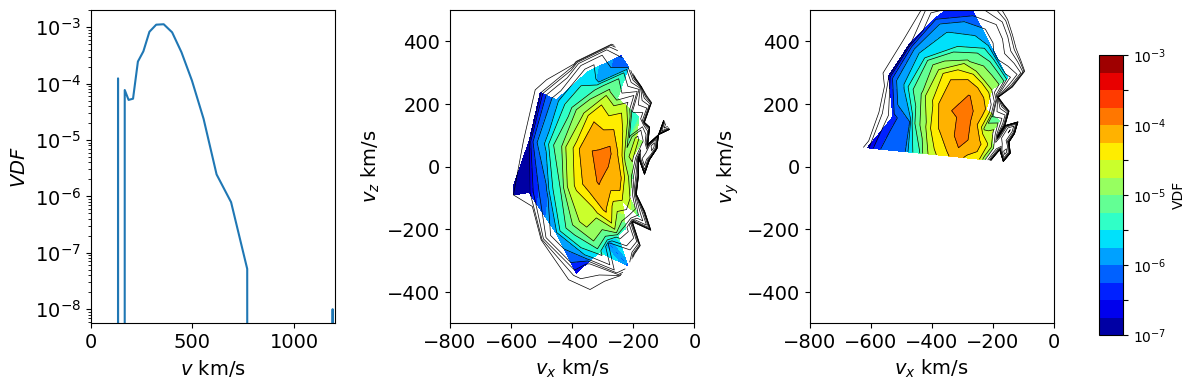

In [4]:
#getting vdf
epoch_req=np.datetime64(datetime(2022, 2, 25, 15,0 ,0))
# Find index in epoch_vdf corresponding to the requested epoch
k = bisect.bisect_left(epoch_vdf, epoch_req)

# Create the figure and subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
font_s = 14

# Plotting on ax0
#counts_all[k][counts_all[k] == 0] = np.nan  # Replace zeros with NaN to avoid log scale issues
#ax0.set_ylim(1e0, 1e3)
#ax0.plot(vel_all[k], counts_all[k])
ax0.plot(vel_all[k], vdf_all[k])
ax0.set_xlim(0, 1200)
ax0.set_yscale("log")
ax0.set_xlabel('$v$ km/s', fontsize=font_s)
#ax0.set_ylabel('$Counts$', fontsize=font_s)
ax0.set_ylabel('$VDF$', fontsize=font_s)
ax0.tick_params(axis='y', which='major', labelsize=font_s)
ax0.tick_params(axis='x', which='major', labelsize=font_s)
ax0.yaxis.get_label().set_fontsize(font_s)
ax0.xaxis.get_label().set_fontsize(font_s)

# Contour plot for ax1 (theta)
#cs1 = ax1.contourf(vx_theta[k], vz_theta[k], counts_theta[k], locator=ticker.LogLocator(), cmap=plt.cm.jet, levels=np.logspace(np.log10(1), 4, 25))
#contour_lines1 = ax1.contour(vx_theta[k], vz_theta[k], counts_theta[k], levels=cs1.levels, colors='k', linewidths=0.5)
cs1 = ax1.contourf(vx_theta[k], vz_theta[k], df_theta[k], locator=ticker.LogLocator(), cmap=plt.cm.jet, levels=np.logspace(np.log10(1e-7), np.log10(1e-3), 17))
contour_lines1 = ax1.contour(vx_theta[k], vz_theta[k], df_theta[k], levels=cs1.levels, colors='k', linewidths=0.5)
ax1.set_xlim(-800, 0)
ax1.set_ylim(-500, 500)
ax1.set_xlabel('$v_x$ km/s', fontsize=font_s)
ax1.set_ylabel('$v_z$ km/s', fontsize=font_s)
ax1.tick_params(axis='y', which='major', labelsize=font_s)
ax1.tick_params(axis='x', which='major', labelsize=font_s)
ax1.yaxis.get_label().set_fontsize(font_s)
ax1.xaxis.get_label().set_fontsize(font_s)

# Contour plot for ax2 (phi)
#cs2 = ax2.contourf(vx_phi[k], vy_phi[k], counts_phi[k], locator=ticker.LogLocator(), cmap=plt.cm.jet, levels=np.logspace(np.log10(1), 4, 25))
#contour_lines2 = ax2.contour(vx_phi[k], vy_phi[k], counts_phi[k], levels=cs2.levels, colors='k', linewidths=0.5)
cs2 = ax2.contourf(vx_phi[k], vy_phi[k], df_phi[k], locator=ticker.LogLocator(), cmap=plt.cm.jet, levels=np.logspace(np.log10(1e-7), np.log10(1e-3), 17))
contour_lines2 = ax2.contour(vx_phi[k], vy_phi[k], df_phi[k], levels=cs2.levels, colors='k', linewidths=0.5)
ax2.set_xlim(-800, 0)
ax2.set_ylim(-500, 500)
ax2.set_xlabel('$v_x$ km/s', fontsize=font_s)
ax2.set_ylabel('$v_y$ km/s', fontsize=font_s)
ax2.tick_params(axis='y', which='major', labelsize=font_s)
ax2.tick_params(axis='x', which='major', labelsize=font_s)
ax2.yaxis.get_label().set_fontsize(font_s)
ax2.xaxis.get_label().set_fontsize(font_s)

# Reduce spacing between subplots
plt.subplots_adjust(wspace=0.1)  # Adjust this to reduce spacing between subplots

# Add colorbar for cs2 only once (outside loops)
cbar_ax1 = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust colorbar position manually (reduce overlap)
#fig.colorbar(cs2, cax=cbar_ax1, orientation='vertical', label='Counts')
fig.colorbar(cs2, cax=cbar_ax1, orientation='vertical', label='VDF')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust right edge to make space for colorbar
plt.show()

Getting Solo VDF 

In [56]:
#Interactive data explore and download
#from pyspedas.cdagui.cdagui import cdagui
#cdagui()


09-Sep-24 22:18:44: Downloading https://cdaweb.gsfc.nasa.gov/sp_phys/data/solar-orbiter/swa/science/l2/pas-vdf/2022/solo_l2_swa-pas-vdf_20220227_v02.cdf to C:\Users\Yogi\GSFC\PSP_SPA-I\cdaweb\solar-orbiter\swa\science\l2\pas-vdf\2022\solo_l2_swa-pas-vdf_20220227_v02.cdf
09-Sep-24 22:19:03: Download complete: C:\Users\Yogi\GSFC\PSP_SPA-I\cdaweb\solar-orbiter\swa\science\l2\pas-vdf\2022\solo_l2_swa-pas-vdf_20220227_v02.cdf
09-Sep-24 22:19:03: Downloaded 1 CDF files.
09-Sep-24 22:19:37: Number of tplot variables loaded:4
09-Sep-24 22:19:37: ['quality_factor', 'total_count', 'unrecovered_count', 'vdf']


In [5]:
#SOLO VDF Data
#put the data file in same directory
solo_pas = cdflib.CDF('solo_l2_swa-pas-vdf_20220227_v02.cdf')
solo_epoch           = cdflib.cdfepoch.to_datetime(solo_pas['Epoch'])
solo_theta           = solo_pas['Azimuth']
solo_phi             = solo_pas['Elevation']
solo_energy          = solo_pas['Energy']
solo_vdf             = solo_pas['vdf']
solo_data            = solo_pas['total_count']

In [73]:
solo_vdf.cdf_info()

CDFInfo(CDF=WindowsPath('C:/Users/Yogi/GSFC/PSP_SPA-I/solo_l2_swa-pas-vdf_20220227_v02.cdf'), Version='3.9.0', Encoding=1, Majority='Row_major', rVariables=[], zVariables=['Epoch', 'Half_interval', 'SCET', 'Info', 'unrecovered_count', 'total_count', 'quality_factor', 'start_energy', 'nb_energy', 'start_elevation', 'nb_elevation', 'start_CEM', 'nb_CEM', 'nb_K', 'K', 'PAS_to_RTN', 'vdf', 'Energy', 'delta_p_Energy', 'delta_m_Energy', 'Azimuth', 'Elevation', 'delta_Azimuth', 'delta_Elevation', 'Elevation_correction', 'Full_elevation', 'Full_azimuth'], Attributes=[{'Project': 'Global'}, {'Source_name': 'Global'}, {'Discipline': 'Global'}, {'Data_type': 'Global'}, {'Descriptor': 'Global'}, {'Data_version': 'Global'}, {'PI_name': 'Global'}, {'PI_affiliation': 'Global'}, {'Text': 'Global'}, {'Instrument_type': 'Global'}, {'Mission_group': 'Global'}, {'Logical_source': 'Global'}, {'Logical_file_id': 'Global'}, {'Logical_source_description': 'Global'}, {'Time_resolution': 'Global'}, {'Rules_of_u

In [85]:
solo_vdf[0].shape

(11, 9, 96)

In [6]:
# creating 3D matrix for theta, and phi and energy
##Theta
solo_theta3d = np.tile(solo_theta[:, np.newaxis, np.newaxis], (1, 9, 96))
##Phi
solo_phi3d = np.tile(solo_phi[np.newaxis,:, np.newaxis], (11, 1, 96))
## Energy
solo_energy3d = np.tile(solo_energy[np.newaxis, np.newaxis,:], (11, 9, 1))
print(solo_theta3d.shape,solo_phi3d.shape,solo_energy3d.shape,solo_vdf.shape)

(11, 9, 96) (11, 9, 96) (11, 9, 96) (21486, 11, 9, 96)


In [7]:
#Creating vx,vy,vz
#using proton parameters only
mass_p = 0.010438870  # eV/c^2 where c = 299792 km/s
charge_p = 1  # eV

solo_vel = np.sqrt(2 * charge_p * solo_energy3d / mass_p)

solo_vx = solo_vel * np.cos(np.radians(solo_phi3d)) * np.cos(np.radians(solo_theta3d))
solo_vy = solo_vel * np.sin(np.radians(solo_phi3d)) * np.cos(np.radians(solo_theta3d))
solo_vz = solo_vel * np.sin(np.radians(solo_theta3d))

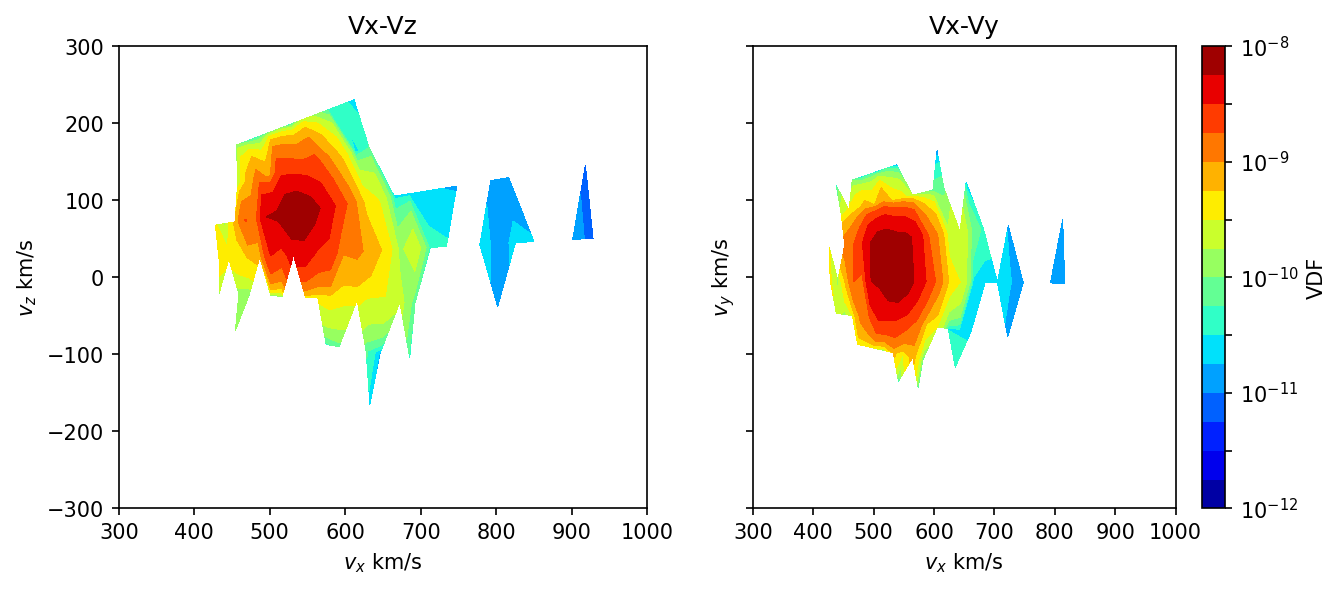

In [8]:
epoch_req=np.datetime64(datetime(2022, 2, 27, 15,0 ,0))
# Find index in epoch_vdf corresponding to the requested epoch
k=bisect.bisect_left(solo_epoch, epoch_req)
solo_vdfs=solo_vdf[k,:,:,:]
fig, axs = plt.subplots(1, 2, sharex=True,sharey=True, dpi=150,figsize=(10, 4))

log_levels = np.linspace(np.log10(1e-12), np.log10(1e-8), 17)
# log_levels = np.linspace(np.log10(1e-1), np.log10(1e3), 17)
levels = 10**log_levels
cmap = cm.jet

n=np.where(solo_vdfs==np.nanmax(solo_vdfs))
contour0 = axs[0].contourf(solo_vx[:,n[1][0],:], solo_vz[:,n[1][0],:], solo_vdfs[:,n[1][0],:], locator=ticker.LogLocator(), cmap=cmap, levels=levels)
#contour0 = axs[0, 0].contourf(x, y, data, locator=ticker.LogLocator(), cmap=cmap, levels=levels)
axs[0].set_xlim(300,1000)
axs[0].set_ylim(-300, 300)
axs[0].set_title('Vx-Vz')
axs[0].set_xlabel('$v_x$ km/s')
axs[0].set_ylabel('$v_z$ km/s')
#fig.colorbar(contour0, ax=axs[0])  # Add colorbar to the subplot

contour0 = axs[1].contourf(solo_vx[n[0][0],:,:], solo_vy[n[0][0],:,:], solo_vdfs[n[0][0],:,:], locator=ticker.LogLocator(), cmap=cmap, levels=levels)
#contour0 = axs[0, 0].contourf(x, y, data, locator=ticker.LogLocator(), cmap=cmap, levels=levels)
axs[1].set_xlim(300,1000)
axs[1].set_ylim(-300, 300)
axs[1].set_title('Vx-Vy')
axs[1].set_xlabel('$v_x$ km/s')
axs[1].set_ylabel('$v_y$ km/s')
fig.colorbar(contour0, ax=axs[1], label='VDF')  # Add colorbar to the subplot

In [148]:
np.nanmax(solo_vdfs)

np.float32(8.577647e-09)

In [203]:
df_e.iloc[9000]

epochl2                 748243790275436800
jdtot                       2460205.228253
denstot                                NaN
0                                      NaN
1                                      NaN
flagtot                                  0
tcore                                  NaN
thproxy                                NaN
time       [2023-09-17T17:28:41.091436800]
Name: 9000, dtype: object